In [1]:
import numpy as np
import pandas as pd
import json, os, glob
from os.path import join
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
def make_numpy_array(file, db_type):
  if db_type == 'all':
    result = np.zeros((37,120))
  elif db_type == 'body':
    result = np.zeros((37,36))
  elif db_type == 'hands':
    result = np.zeros((37,84))
  
  for k in sorted(list(file['data'].keys())):
    k_int = int(k)
    try:
      data = file['data'][k][0]
      
      if db_type == 'all':
        bla = np.r_[data['pose_keypoints'], data['hand_left_keypoints'], data['hand_right_keypoints']]
      if db_type == 'body':
        bla = data['pose_keypoints']
      if db_type == 'hands':
        bla = np.r_[data['hand_left_keypoints'], data['hand_right_keypoints']]
        
      bla = bla[[False if i %3 ==2 else True for i in range(len(bla))]]
      result[k_int-1] = bla
    except:
      None
  return result

def get_class(file):
  f_id = re.findall(r'([0-9]*).json', file)[0]
  f_label = id_label_dict[f_id]
  f_class = label_class_dict[f_label]
  
  return f_class




In [3]:
db_type = 'hands'


json_dir= '../../data/json_3/'
train_dir = '../../data/train/'

files = os.listdir(json_dir)

train_labels = '../labels/train.csv'
val_labels = '../labels/validation.csv'
all_labels = '../labels/labels.csv'

labels = pd.read_csv(train_labels, index_col=0, sep=';', header=None)
labels = json.loads(labels.to_json())['1']

validation_labels = pd.read_csv(val_labels, index_col=0, sep=';', header=None)
validation_labels = json.loads(validation_labels.to_json())['1']

labels.update(validation_labels)
id_label_dict = labels
df = pd.read_csv(all_labels, header = None).reset_index()
label_class_dict = dict(df[[0,'index']].values)

In [7]:
len(files)

20263

In [17]:
all_labels_red = []
hand_percentage = []
test_data = 0
for i, file in enumerate(files):
  # If there is a file that is not a json (.DS_store wtf)
  if 'json' not in file:
    continue
    
  # Load the json file
  with open(join(json_dir,file),'rb') as f:
    json_all = json.load(f)
    
  if json_all['label'] == '?':
    test_data += 1
    continue
    
  json_data = json_all['data']
  # Check the number of frames
  json_frames = sorted(json_data.keys())
  num_frames = len(json_frames)
  
  if int(json_frames[-1]) > 38 | int(json_frames[-1]) < 30:
    continue

  no_person = 0
  for k in json_frames:
    try:
      person = json_data[k][0]
    except:
      no_person += 1
      continue
      
  if no_person/num_frames > .2:
    continue
    
  # Check how many actually have hands
  '''
  hands = 0
  for k in json_frames:
    try:
      lhand = sum(json_data[k][0]['hand_left_keypoints']) > 0
      rhand = sum(json_data[k][0]['hand_right_keypoints']) > 0
      if lhand | rhand:
        hands += 1
    except:
      None

  if hands/num_frames == 0:
    continue
  '''
  
  result = make_numpy_array(json_all, db_type)
  
  output_dir = join(train_dir,db_type,file[:-5])
  #np.save(output_dir, result) 
  
  
  # Check the label
  #hand_percentage.append(hands/num_frames)
  all_labels_red.append(json_all['label'])

In [18]:
len(files) - test_data

18305

17054


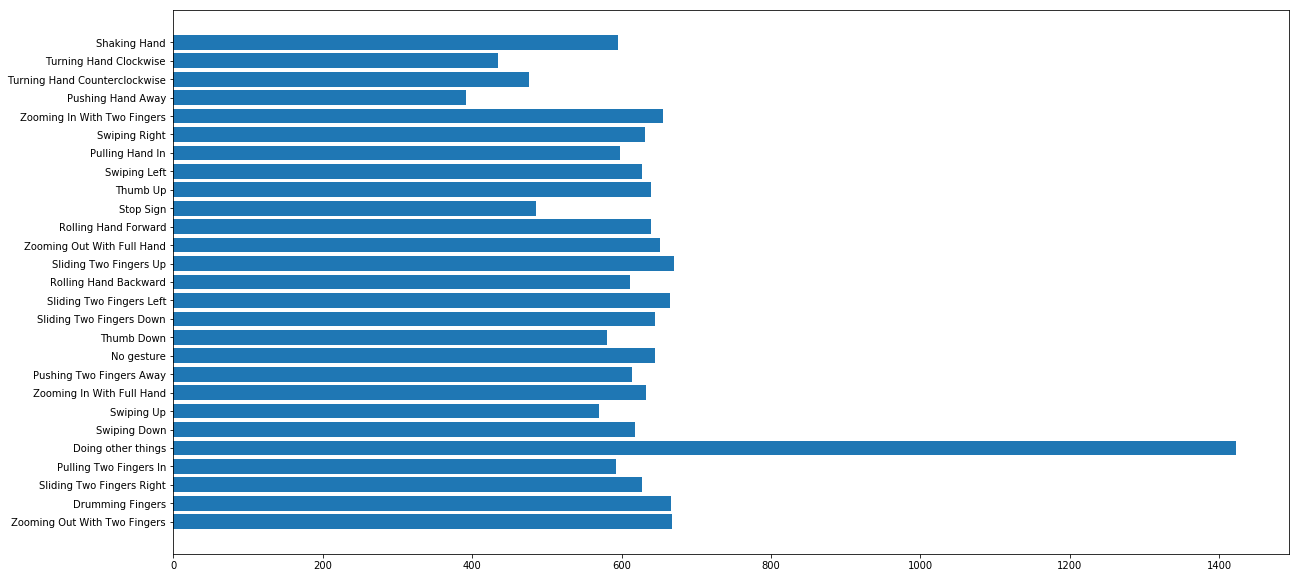

In [20]:
print(len(all_labels_red))
count = Counter(all_labels_red)
x, y = count.keys(), count.values()
plt.figure(figsize= (20,10))
plt.barh(list(range(len(x))), y)
_ = plt.yticks(list(range(len(x))),x)
plt.savefig('distribution_of_labels')